In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

#Load the MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Add new layers
x = base_model.output

# Global Average Pooling Layer
x = GlobalAveragePooling2D()(x)

# Add Dense layers
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

#Freeze layers
for layer in model.layers[:86]:
    layer.trainable = False

#Unfreeze layers
for layer in model.layers[86:]:
    layer.trainable = True

#Summary and compile the model
model.summary()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Data preprocessing and image data gen
seed_value = 42
seed_val = 123
batch_size = 32

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    fill_mode="nearest",
)

#Create Train Image generator
train_generator = datagen.flow_from_directory(
    './Train/', 
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed_value,
    shuffle=True
)

#Create Validation Image generator
val_generator = datagen.flow_from_directory(
    './Validate/',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed_val,
    shuffle=True
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

Found 97 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


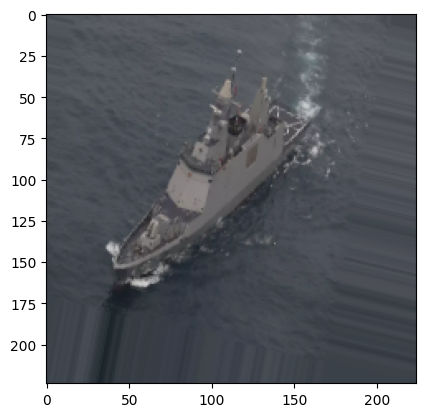

In [6]:
batch = train_generator.next()
images = batch[0]
scaled_images = (images + 1.0) / 2.0
plt.imshow(scaled_images[0])
plt.show()

In [12]:
#Create Optimizer
opts = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opts, metrics=['accuracy'])
eps = 100
step_size_train = train_generator.n // train_generator.batch_size
step_size_val = val_generator.n // val_generator.batch_size

#Check step size train = step size val
if step_size_train != step_size_val:
    print("Warning: step_size_train is not equal to step_size_val.")
    new_batch_size = val_generator.n // step_size_train
    val_generator = datagen.flow_from_directory(
        './Validate/',
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=new_batch_size,
        class_mode='categorical',
        seed=seed_val,
        shuffle=True
    )
    step_size_val = val_generator.n // val_generator.batch_size
    print(f"Adjusted batch size to {new_batch_size} to make step_size_train equal to step_size_val.")

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=step_size_train,
                              validation_data=val_generator,
                              validation_steps=step_size_val,
                              epochs=eps,
                              verbose=1)

#Performance Visualization
epochs = range(1, 100 + 1)

C:\Users\dream\AppData\Local\Temp\ipykernel_10188\2866291.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/100
3/3 [==============================] - 9s 3s/step - loss: 0.2645 - accuracy: 0.8923 - val_loss: 0.3530 - val_accuracy: 0.8551
Epoch 2/100
3/3 [==============================] - 5s 2s/step - loss: 0.2349 - accuracy: 0.9077 - val_loss: 0.1983 - val_accuracy: 0.9710
Epoch 3/100
3/3 [==============================] - 5s 2s/step - loss: 0.1816 - accuracy: 0.9538 - val_loss: 0.1652 - val_accuracy: 0.9710
Epoch 4/100
3/3 [==============================] - 5s 2s/step - loss: 0.1763 - accuracy: 0.9692 - val_loss: 0.1789 - val_accuracy: 0.9565
Epoch 5/100
3/3 [==============================] - 5s 2s/step - loss: 0.2014 - accuracy: 0.9385 - val_loss: 0.1574 - val_accuracy: 0.9565
Epoch 6/100
3/3 [==============================] - 5s 2s/step - loss: 0.1629 - accuracy: 0.9692 - val_loss: 0.2513 - val_accuracy: 0.9130
Epoch 7/100
3/3 [==============================] - 5s 2s/step - loss: 0.2080 - accuracy: 0.9077 - val_loss: 0.2552 - val_accuracy: 0.8986
Epoch 8/100
3/3 [=================

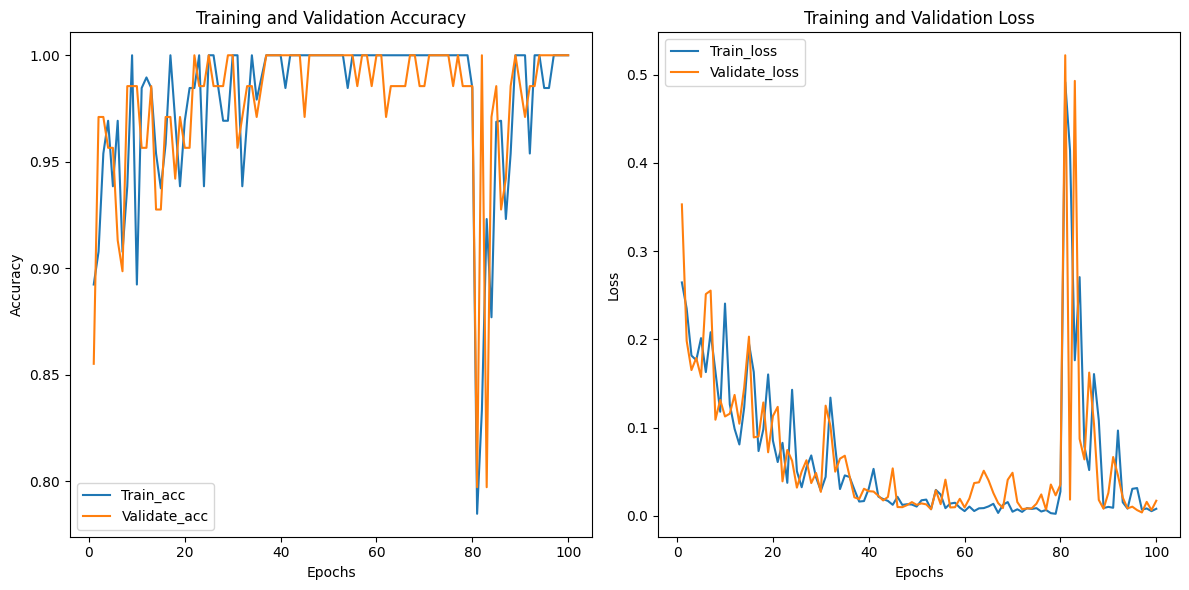

In [13]:
#View Accuracy (Training, Validation)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="Train_acc")
plt.plot(epochs, history.history["val_accuracy"], label="Validate_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

#View Loss (Training, Validation)
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label="Train_loss")
plt.plot(epochs, history.history['val_loss'], label="Validate_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()